In [1]:
import numpy as np
import os

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
#import imageio

from scipy.stats import ks_2samp
from scipy.special import erfinv

torch.manual_seed(1)    # reproducible
np.random.seed(1)

os.chdir('../src')
from regression_analysis import guassian_comparison_ratio, correct_compare_hist

In [2]:
training_sample_n = 5000
test_sample_n = 5000

In [3]:
#x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
#y = torch.sin(x) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
data_x = np.random.random_sample(training_sample_n)*np.pi*2
#data_y = np.random.random_sample(50000)*np.pi*2
data_z = np.sin(data_x) + np.cos(data_x)
data_z = (data_z - np.min(data_z))/(np.max(data_z) - np.min(data_z))

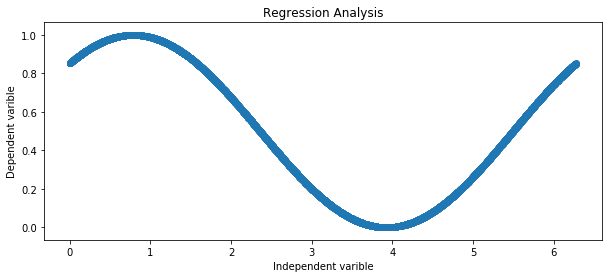

In [4]:
# torch can only train on Variable, so convert them to Variable
#x, y = Variable(x), Variable(y)
plt.figure(figsize=(10,4))
#plt.scatter(x.data.np(), y.data.np(), color = "blue")
plt.scatter(data_x, data_z)
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
#plt.savefig('curve_2.png')
plt.show()

In [5]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_first, n_second, n_output):
        super(Net, self).__init__()
        self.first = torch.nn.Linear(n_feature, n_first)   # hidden layer
        self.second = torch.nn.Linear(n_first, n_second)   # output layer
        self.predict = torch.nn.Linear(n_second, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.first(x))      # activation function for hidden layer
        x = F.relu(self.second(x))  
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_first=200, n_second=100, n_output=1)     # define the network
# print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss)

In [6]:
data_x_torch = Variable(torch.from_numpy(data_x.reshape(len(data_x),1)))
data_z_torch = Variable(torch.from_numpy(data_z.reshape(len(data_x),1)))

In [7]:
net = net.float()

In [8]:
torch_dataset = Data.TensorDataset(data_x_torch.float(), data_z_torch.float())

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=32, 
    shuffle=True, num_workers=2,)

In [9]:
loss_values = []
EPOCHS = 20
# train the network
for epoch in range(EPOCHS):
    if (epoch%int(EPOCHS/10.) == 0): print(epoch)
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
        #loss_values.append(loss.item())
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    #loss_values.append(loss_func(net(data_x_torch.float()), data_z_torch.float()).item())
    loss_values.append(loss_func(net(data_x_torch.float()), data_z_torch.float()).item())

0
2
4
6
8
10
12
14
16
18


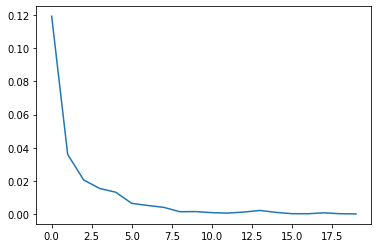

In [10]:
plt.plot(range(len(loss_values)),loss_values)
plt.show()

In [11]:
test_x = np.random.random_sample(test_sample_n)*np.pi*2

In [12]:
true_z = np.sin(test_x) + np.cos(test_x)
true_z = (true_z - np.min(true_z))/(np.max(true_z) - np.min(true_z))

In [13]:
test_x_torch = Variable(torch.from_numpy(test_x.reshape(len(test_x),1)).float())
test_z_torch = net(test_x_torch)

In [14]:
error = torch.sqrt(torch.mul(test_z_torch - torch.from_numpy(true_z).float(), test_z_torch - torch.from_numpy(true_z).float()))*100.

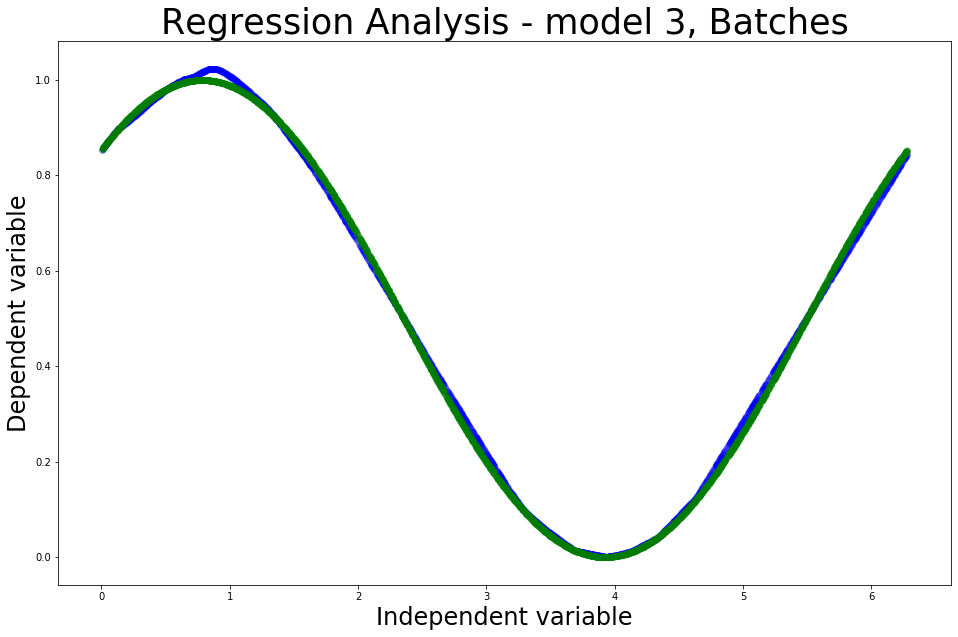

In [22]:
fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Regression Analysis - model 3, Batches', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
#ax.set_xlim(-11.0, 13.0)
#ax.set_ylim(-1.1, 1.2)
ax.scatter(test_x, test_z_torch.data.numpy(), color = "blue", alpha=0.1)
#prediction = net(x)     # input x and predict based on x
ax.scatter(test_x, true_z, color='green', alpha=0.2)
#plt.savefig('curve_2_model_3_batches.png')
plt.show()

In [16]:
ratio = guassian_comparison_ratio(test_z_torch.data.numpy().reshape(len(true_z)), true_z)

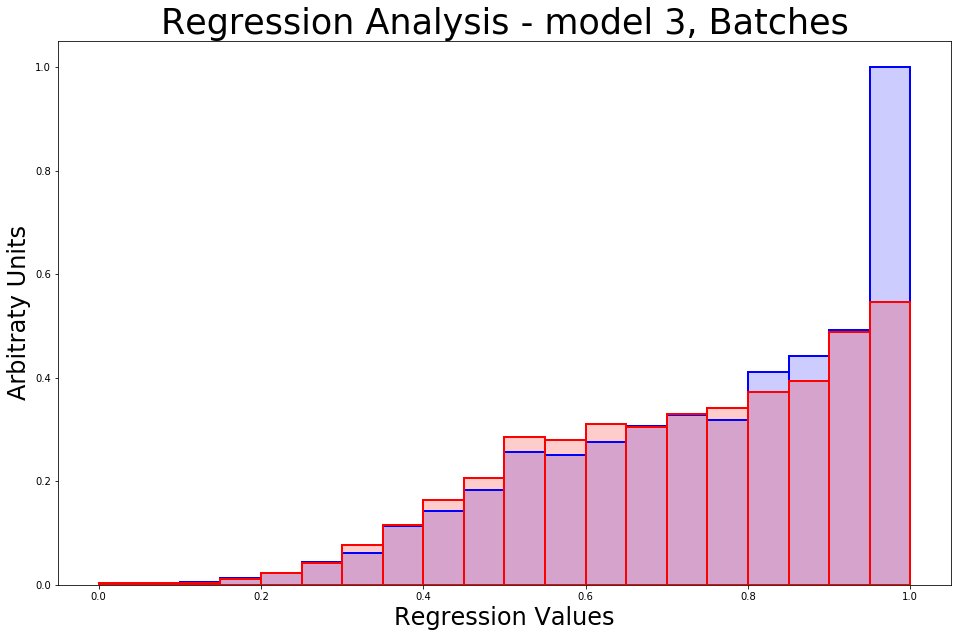

In [17]:
hist1, hist2 = correct_compare_hist(true_z, test_z_torch, ratio)

Quick Kolmogorov–Smirnov test

In [20]:
ks_2samp(hist1, hist2)

Ks_2sampResult(statistic=0.15, pvalue=0.9831368772656193)